# Mixing in the magnetic field of the Milky Way

In [1]:
# to import gammaALPs, this cell should be only executed once after kernel restart
%cd ..
%cd ..

/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs/notebooks
/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs


/home/flandgraf/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
import time

fatal: No names found, cannot describe anything.


In [3]:
# effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # used for plotting

Next we initialize the module. We assume a pure ALP beam as the initial state that enters the Milky Way.

In [4]:
EGeV = np.logspace(-1., 3., 101)  # the energy range, roughly matching the Fermi-LAT energy range
src = Source(z=0.017559, l=20., b=20.)  # some dummy source for initialization
pa_in = np.diag([0., 0., 1.])  # the inital polarization matrix; a pure ALP state

ml = [ModuleList(ALP(m=1., g=1.), src, pin=pa_in, EGeV=EGeV, seed=0) for i in range(8)]

models = ['base', 'expX', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', 'spur']
for i in range(8):
    ml[i].add_propagation("GMF", 0, model='UF23', UF23_model=models[i])

environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi
environs.py:1207 --- INFO: Using inputted chi


## Compute conversion probability

In [5]:
px, py, pa = np.zeros((3, 8, EGeV.size))

In [6]:
prx, pry, pra = np.zeros((3, 8, 99, EGeV.size))

In [7]:
prx.shape

(8, 99, 101)

Compute the conversion probability along the line of sight. We provide the initial state and the final polarization state we're interested in.

In [8]:
px_in = np.diag([1., 0., 0.])
py_in = np.diag([0., 1., 0.])

for i in range(8):
    px[i], py[i], pa[i] = ml[i].run()
    prx[i] = (ml[i].modules["GMF"].show_conv_prob_vs_r(pa_in, px_in))
    pry[i] = (ml[i].modules["GMF"].show_conv_prob_vs_r(pa_in, py_in))
    pra[i] = (ml[i].modules["GMF"].show_conv_prob_vs_r(pa_in, pa_in))

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real va

Plot the conversion probability for one fixed energy as a function of propagation disctance together with the transversal magnetic field strength.

Energy: 3.981071705534973 GeV


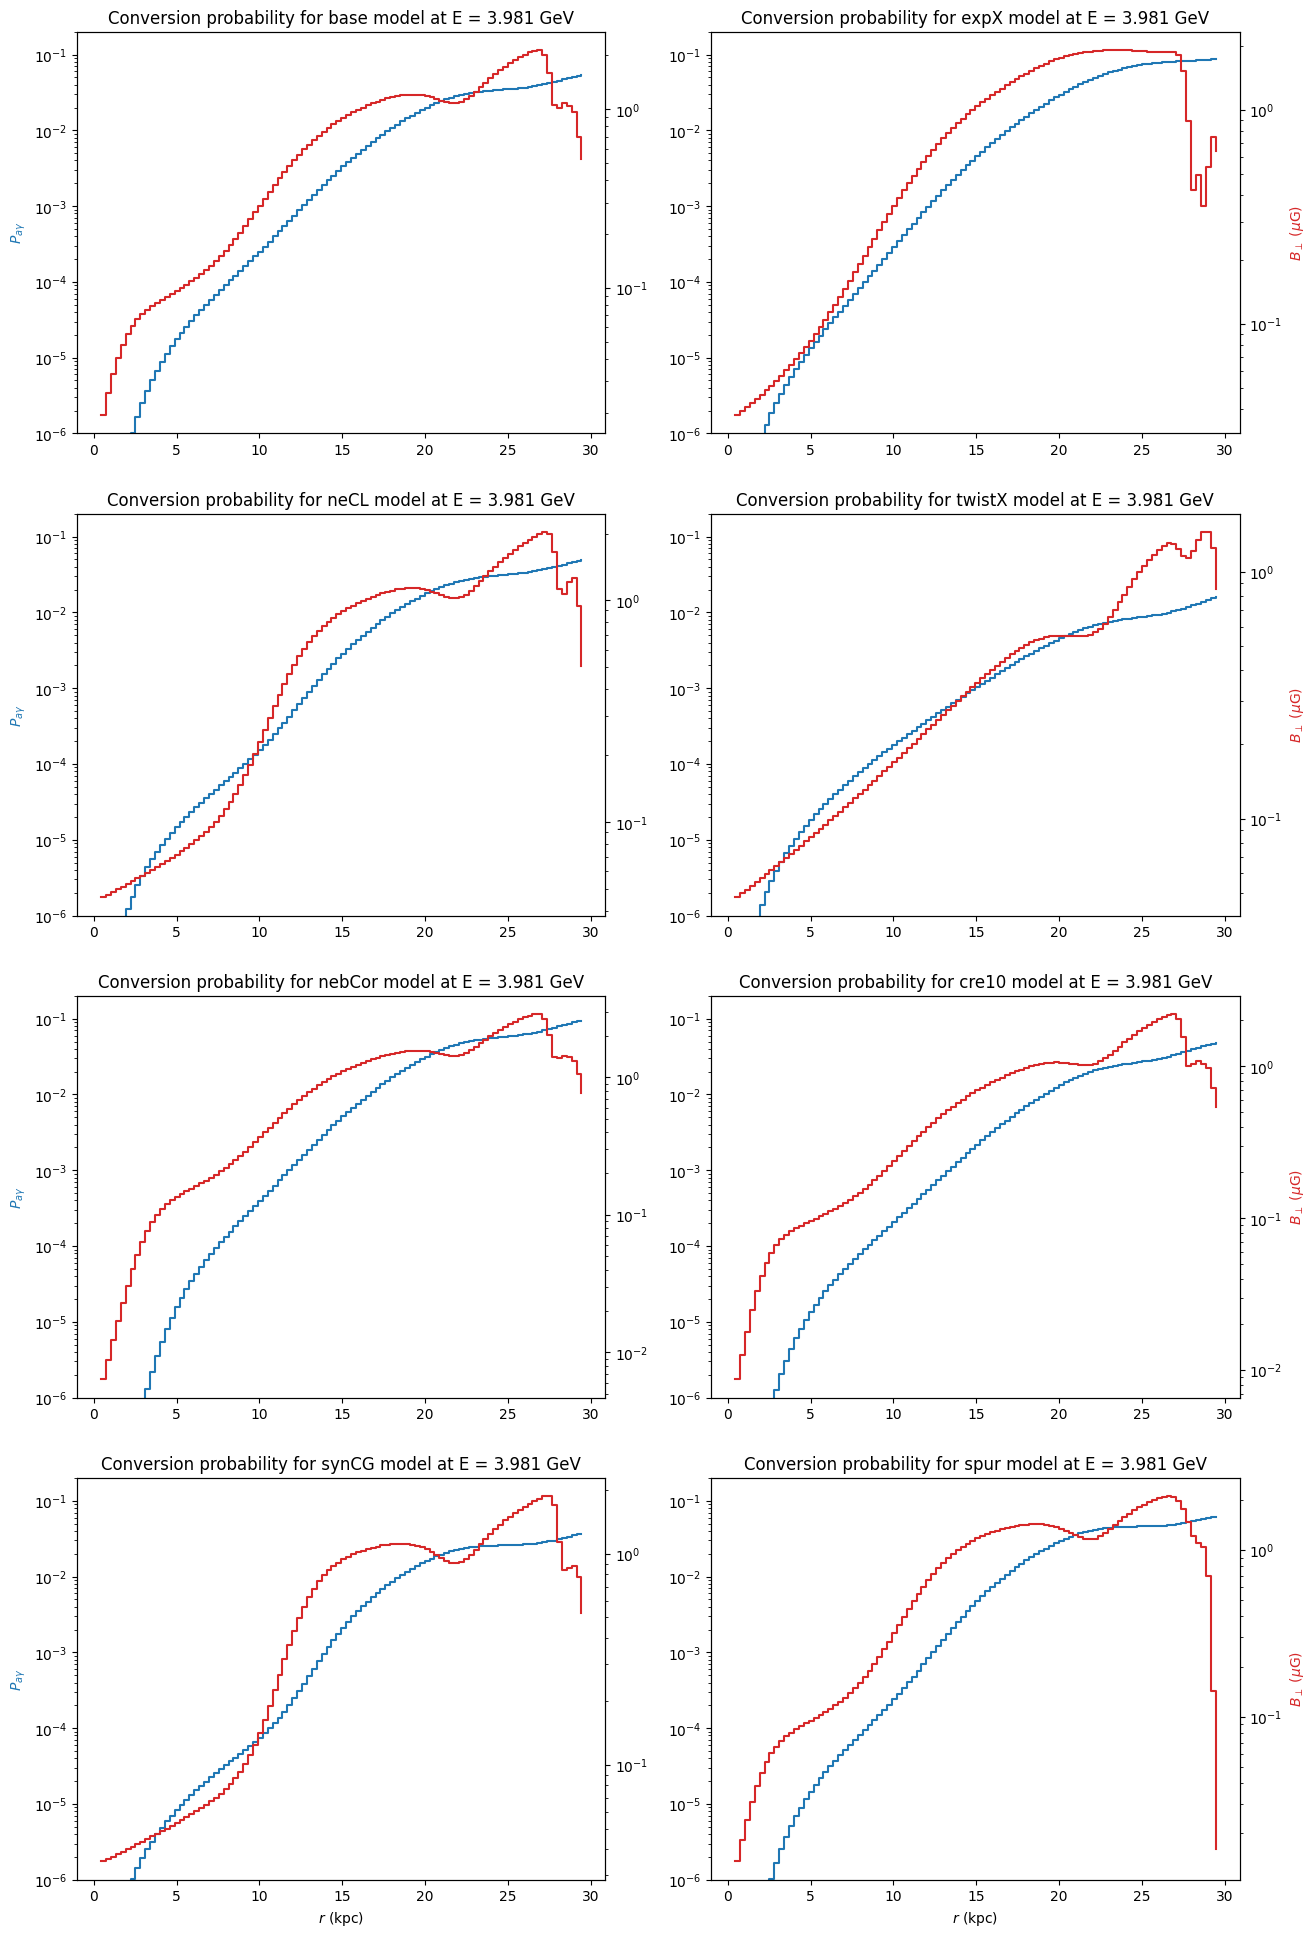

In [9]:
E = 4
idx = np.absolute(EGeV-E).argmin()
print ("Energy:", EGeV[idx], "GeV")

fig, axs = plt.subplots(4,2, figsize=(15, 24))

for i, ax in enumerate(axs.flat):
    ax.set_title(f"Conversion probability for {models[i]} model at E = {round(EGeV[idx],3)} GeV")
    ax.semilogy(ml[i].modules["GMF"].r, (prx[i][:,idx] + pry[i][:,idx])[::-1],
                drawstyle='steps')
    
    ax.set_ylabel(r"$P_{a \gamma}$", color = plt.cm.tab10(0.))
    ax.set_xlabel("$r$ (kpc)")
    ax.set_ylim(1e-6,2e-1)
    
    ax2 = ax.twinx()
    ax2.semilogy(ml[i].modules["GMF"].r, ml[i].modules["GMF"].B[::-1],
                 color = plt.cm.tab10(0.3),
                 drawstyle ='steps')
    
    ax2.set_ylabel(r"$B_{\perp}$ ($\mu$G)", color = plt.cm.tab10(0.3))
    ax.label_outer()
    ax2.label_outer()
    ax.tick_params(axis="both", which="both", labelbottom = True, labelleft = True)
    ax2.tick_params(axis="both", which="both", labelbottom = True, labelright = True)

plt.show()

### Plot the total conversion probability as a function of energy:

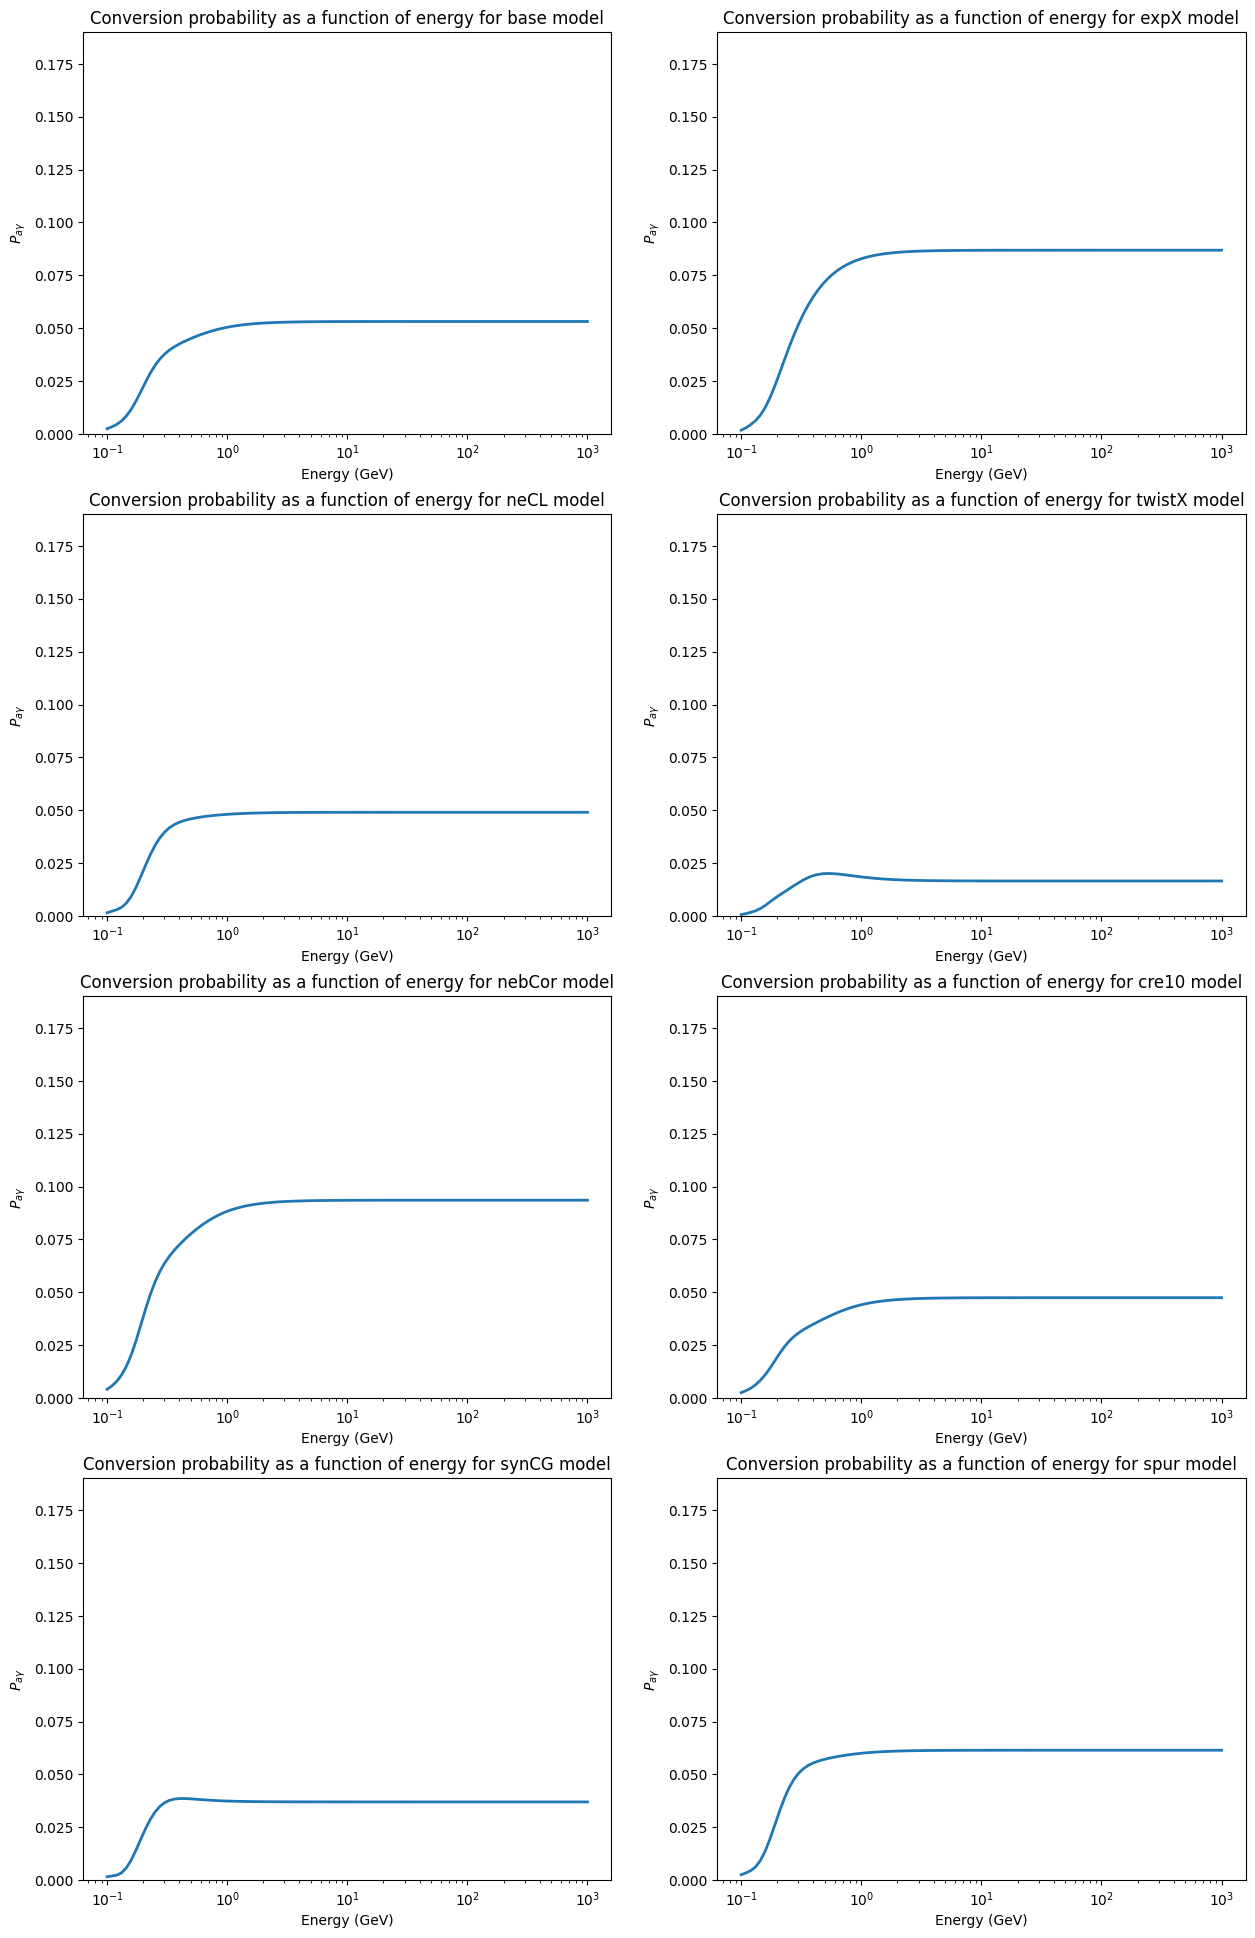

In [10]:
fig, axs = plt.subplots(4,2, figsize=(15, 24))

for i, ax in enumerate(axs.flat):
    ax.set_title(f"Conversion probability as a function of energy for {models[i]} model")
    ax.semilogx(EGeV, px[i] + py[i], lw = 2)

    ax.set_ylim(0, 0.19)
    ax.set_ylabel(r"$P_{a\gamma}$")
    ax.set_xlabel("Energy (GeV)")

plt.show()

# Sky map for mixing in the GMF

Compute Skymaps using healpy. In each sky pixel we calculate the photon-ALP conversion probability at one single energy (1 GeV).

In [11]:
models = ['base', 'expX', 'spur', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', "jansson12"]

In [12]:
pgg = np.zeros((9, 14700, 1))

for k, model in enumerate(models):
    pgg[k] = np.load(f'notebooks/UF23/data/pggnew/new_pgg_{model}_35.npy')


In [13]:
# pgg1 = np.loadtxt('notebooks/UF23/data/pgg_halo_base_30.txt').reshape(-1, 1)

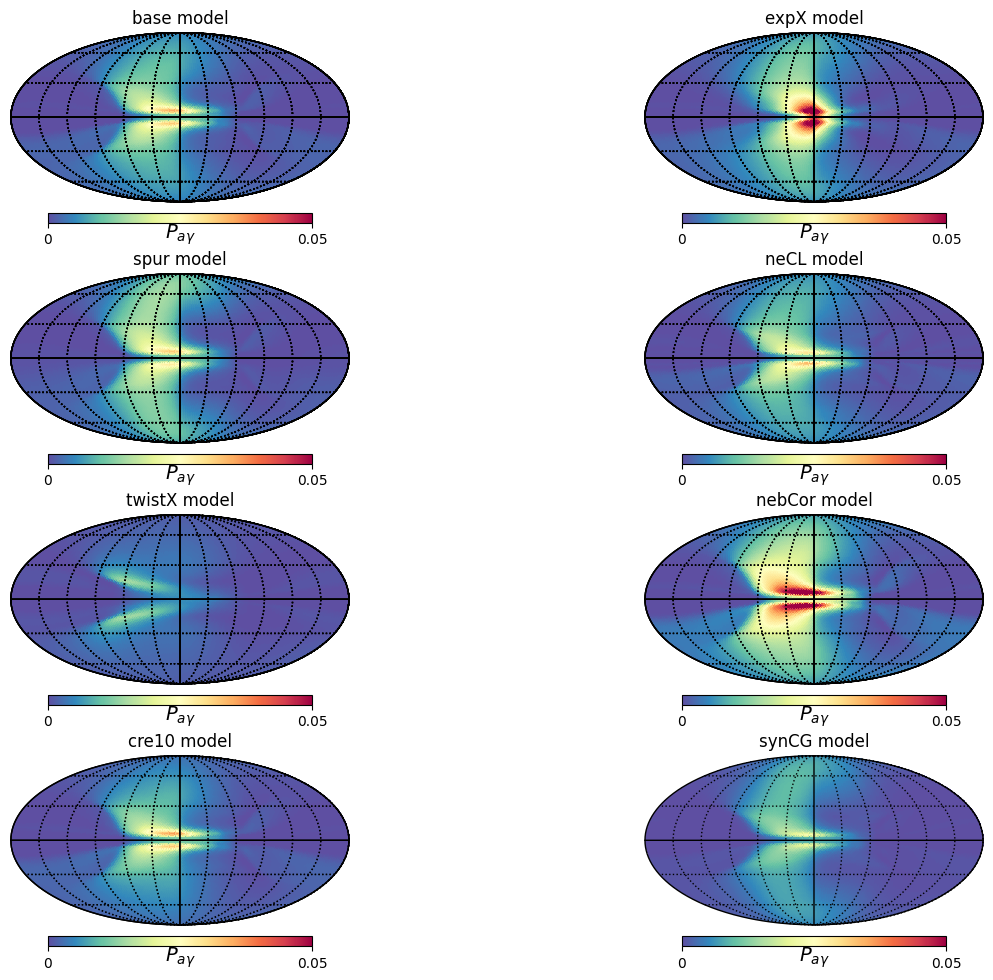

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(15,12))

for k, ax in enumerate(axs.flat):
    plt.sca(ax)
    hpmap = hp.mollview(pgg[k][:,0], 
                        norm='linear',
                        title = f'{models[k]} model', 
                        unit= r'$P_{a\gamma}$', 
                        min=0,
                        max=5e-2, 
                        cmap = 'Spectral_r',
                        hold=True,
                        rot = (0, 0, 0))
    hp.graticule()

plt.savefig('notebooks/UF23/plots/new_skymaps8.png')
plt.show()

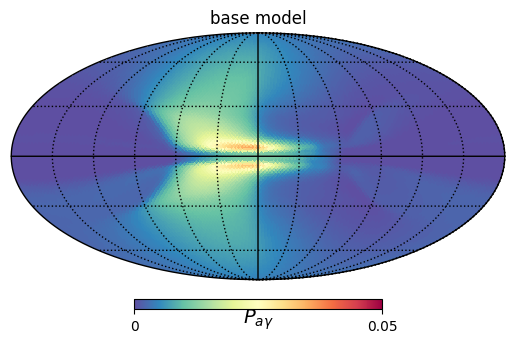

In [15]:
k = 0
hpmap = hp.mollview(pgg[k][:,0], 
                    norm='linear',
                    title = f'{models[k]} model', 
                    unit= r'$P_{a\gamma}$', 
                    min=0,
                    max=5e-2, 
                    cmap = 'Spectral_r',
                    hold=True,
                    rot = (0, 0, 0))
hp.graticule()

# plt.savefig("notebooks/UF23/plots/base.png")
plt.show()

Define the pixel grid

We loop over the coordinates and for each coordinate we re-initialize the ModuleList class and re-calculate the mixing probability